It's important to note that when using PCA, we may not ever know what components are spit out of the algorithm. But the purpose here is to classify, not to necessarily explicitly say what's motivating the classification

In [1]:
import sys
import pickle
sys.path.append("../../courses/machine-learning/ud120-projects/tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
import pandasql as sql
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Task 1: Select what features you'll use.
`features_list` is a list of strings, each of which is a feature name. The first feature must be "poi".

In [2]:
features_list = ['poi','salary', "total_earned_cash_value", 
                "exercised_stock_options"] # You will need to use more features

In [40]:
# Load dict containing dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [41]:
### Two oddities to be dealt with. Robert Belfer's data is incorrectly
### input, as is Sanjay Bhatnagar's.
data_dict["BELFER ROBERT"]["deferred_income"] = -102500
data_dict["BELFER ROBERT"]["deferral_payments"] = 0
data_dict["BELFER ROBERT"]["total_payments"] = 3285
data_dict["BELFER ROBERT"]["exercised_stock_options"] = 0
data_dict["BELFER ROBERT"]["restricted_stock"] = 44093
data_dict["BELFER ROBERT"]["restricted_stock_deferred"] = -44093
data_dict["BELFER ROBERT"]["total_stock_value"] = 0
data_dict["BELFER ROBERT"]["expenses"] = 3285
data_dict["BELFER ROBERT"]["director_fees"] = 102500

data_dict["BHATNAGAR SANJAY"]["expenses"] = 137864
data_dict["BHATNAGAR SANJAY"]["total_payments"] = 137864
data_dict["BHATNAGAR SANJAY"]["total_stock_value"] = 15456290
data_dict["BHATNAGAR SANJAY"]["exercised_stock_options"] = 15456290
data_dict["BHATNAGAR SANJAY"]["restricted_stock"] = 2604490
data_dict["BHATNAGAR SANJAY"]["restricted_stock_deferred"] = -2604490
data_dict["BHATNAGAR SANJAY"]["other"] = 0
data_dict["BHATNAGAR SANJAY"]["director_fees"] = 0

In [42]:
## transform to pandas DF for ease of use
data_df = pd.DataFrame.from_dict(data_dict, orient="index")
data_df.replace("NaN", 0, inplace=True)
data_df.poi = data_df.poi.astype(bool)
data_df.email_address = data_df.email_address.astype("str")
data_df["employee"] = data_df.index

In [43]:
data_df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,employee
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,2195,152,65,False,0,-3081055,304805,phillip.allen@enron.com,47,ALLEN PHILLIP K
BADUM JAMES P,0,0,178980,182466,257817,0,0,0,0,257817,...,0,0,0,False,0,0,0,0,0,BADUM JAMES P
BANNANTINE JAMES M,477,566,0,916197,4046157,0,1757552,465,-560222,5243487,...,29,864523,0,False,0,-5104,0,james.bannantine@enron.com,39,BANNANTINE JAMES M
BAXTER JOHN C,267102,0,1295738,5634343,6680544,1200000,3942714,0,0,10623258,...,0,2660303,0,False,0,-1386055,1586055,0,0,BAXTER JOHN C
BAY FRANKLIN R,239671,0,260455,827696,0,400000,145796,0,-82782,63014,...,0,69,0,False,0,-201641,0,frank.bay@enron.com,0,BAY FRANKLIN R


Let's just look at everything

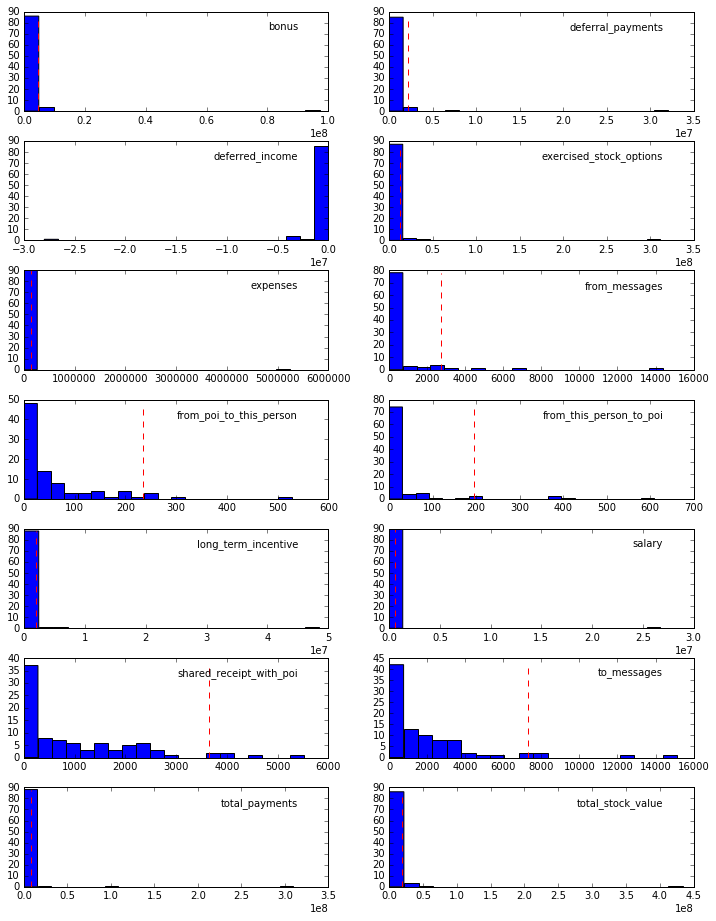

In [80]:
features_list = ["bonus", "deferral_payments", "deferred_income", 
                 "exercised_stock_options", "expenses", "from_messages", 
                 "from_poi_to_this_person", "from_this_person_to_poi", 
                 "long_term_incentive", "salary", "shared_receipt_with_poi",
                 "to_messages", "total_payments", "total_stock_value"]
pct = 0.95

def many_histograms(the_data, features_list):
    fig = plt.figure(figsize=(12,18))
    fig.subplots_adjust(hspace=0.3)
    for ii in range(len(features_list)):
        ax = plt.subplot(len(features_list)/2 + 1, 2, ii+1)
        ax.hist(list(the_data[features_list[ii]]), bins=20)
        H, dum = np.histogram(list(the_data[features_list[ii]]), bins=20)
        ax.plot([the_data[features_list[ii]].quantile(pct), the_data[features_list[ii]].quantile(pct)], 
                [0, max(H)], linestyle="--", color="r")
        ax.text(0.9, 0.9, features_list[ii], transform = ax.transAxes, 
                horizontalalignment="right", verticalalignment="top")

        
    plt.show()
    
many_histograms(data_df, features_list)

**These may benefit from rescaling**
- Total stock value
- 

**These have outliers that must be removed**


### Task 2: Remove outliers
Outliers in this context would be (for my purposes) employees with no
reported salary, no reported total payments, and no total stock value.
I expect my POI classifier will rely on at least one of these (or one of
the components that will contribute to one of the totals), so if all of
these are null, then they're not useful


In [56]:
the_query = "SELECT *"
the_query += " FROM data_df"
the_query += " WHERE total_payments!=0 AND salary!=0 AND total_stock_value!=0"
not_null_employees = sql.sqldf(the_query, locals())
data_df = not_null_employees

Let's take another look at everything, with some pruning done

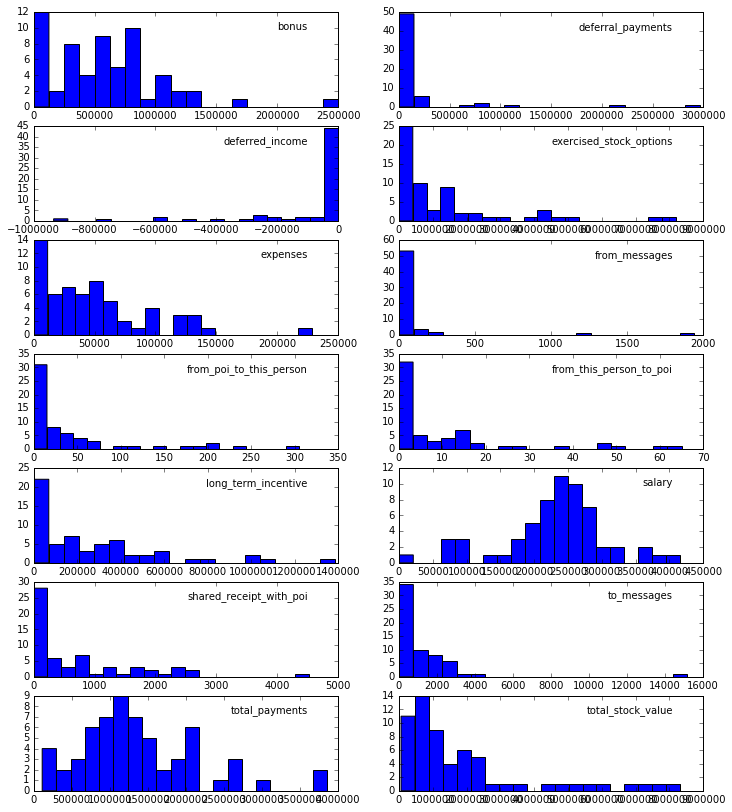

In [58]:
cut = (data_df.bonus < data_df.bonus.quantile(0.9)) & \
    (data_df.salary < data_df.salary.quantile(0.9)) &\
    (data_df.from_this_person_to_poi < data_df.from_this_person_to_poi.quantile(0.9)) &\
    (data_df.long_term_incentive < data_df.long_term_incentive.quantile(0.9)) &\
    (data_df.total_stock_value < data_df.total_stock_value.quantile(0.9))

many_histograms(data_df[cut], features_list)

Initial pruning done. Let's look at everything vs everything

In [72]:
def megaplot(the_data, features):
    indx = 1
    poi = the_data.poi == True

    fig = plt.figure(figsize=(18,18))

    for ii in range(len(features)):
        for jj in range(len(features)):
            if ii != jj:
                ax = plt.subplot(len(features), len(features) - 1, indx)
                ax.scatter(list(the_data[features[jj]][~poi]), 
                           list(the_data[features[ii]][~poi]), 
                           c="b", s=10, edgecolor="None")
                
                ax.scatter(list(the_data[features[jj]][poi]), 
                           list(the_data[features[ii]][poi]), 
                           c="r", s=10, edgecolor="None")
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                if (jj == 0) or ((jj == 1) & (ii == 0)):
                    ax.set_ylabel(features[ii])
                    
                indx += 1
    plt.show()

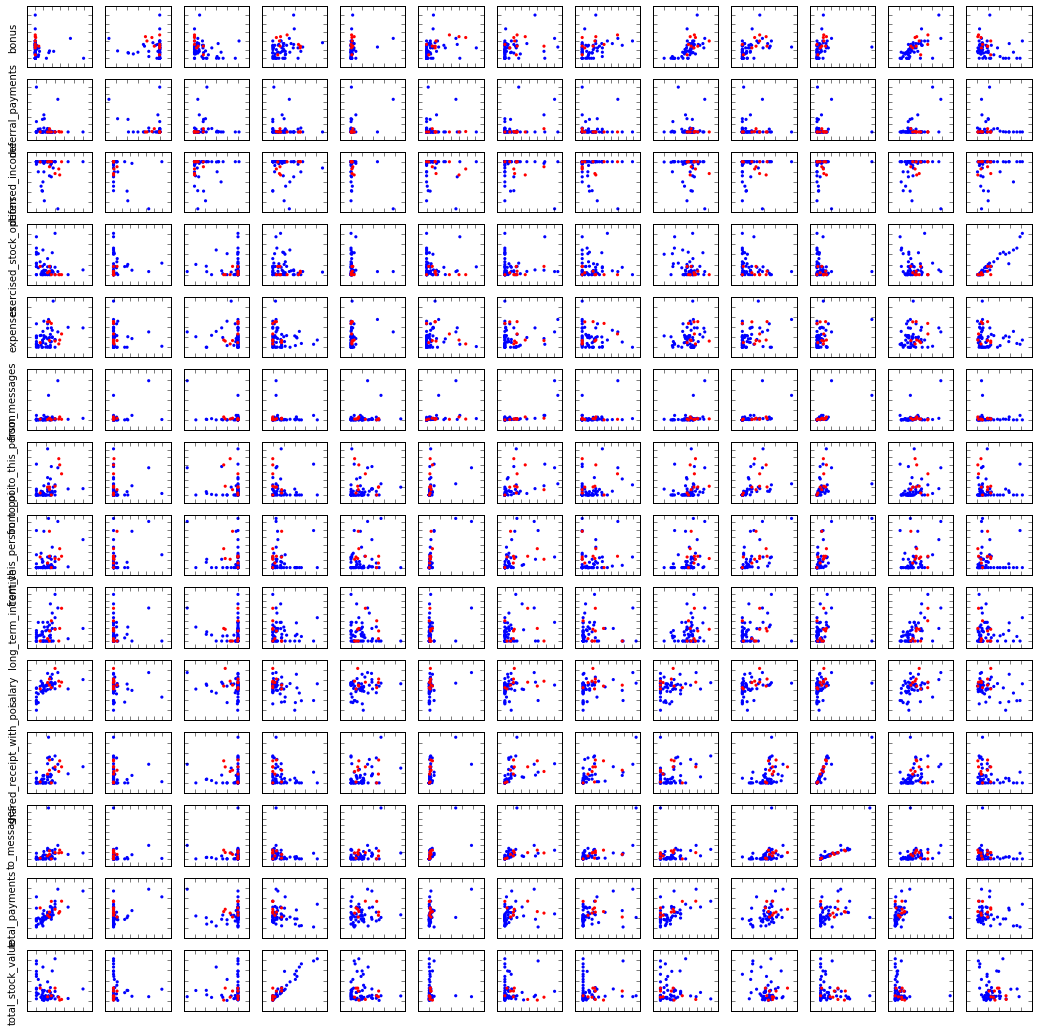

In [73]:
megaplot(data_df[cut], features_list)

Pruning round 2: deferral_payments, from_messages, to_messages, shared_receipt_with_poi

In [ ]:
cut2 = (data_df.deferral_payments < data_df.deferral_payments.quantile(0.9))

## Current Stopping Point
Several features must still be pruned 

### Task 3: Create new feature(s)
One new feature to create will be `total_earned_cash_value`, combining
`salary, bonus, director_fees, expenses, loan_advances, long_term_incentive, deferral_payments` / 0.9, and -(`deferred_income`)

In [12]:
new_col = "total_earned_cash_value"
get_cols = ["salary", "bonus", "director_fees", "expenses", 
            "loan_advances", "long_term_incentive"]
data_df[new_col] = data_df[get_cols].sum(axis=1) + data_df.deferral_payments/0.9 - data_df.deferred_income

Another new feature: `stocks_cash_ratio`

In [13]:
new_col = "stocks_cash_ratio"
data_df[new_col] = data_df.total_stock_value / data_df.total_payments

New features: `total_emails`, `fractions_sent`, `fractions_received`

In [14]:
data_df["total_emails"] = data_df[["from_messages", "to_messages"]].sum(axis=1)
data_df["fractions_sent"] = data_df.from_messages / data_df.total_emails.astype(float)
data_df["fractions_received"] = data_df.to_messages / data_df.total_emails.astype(float)

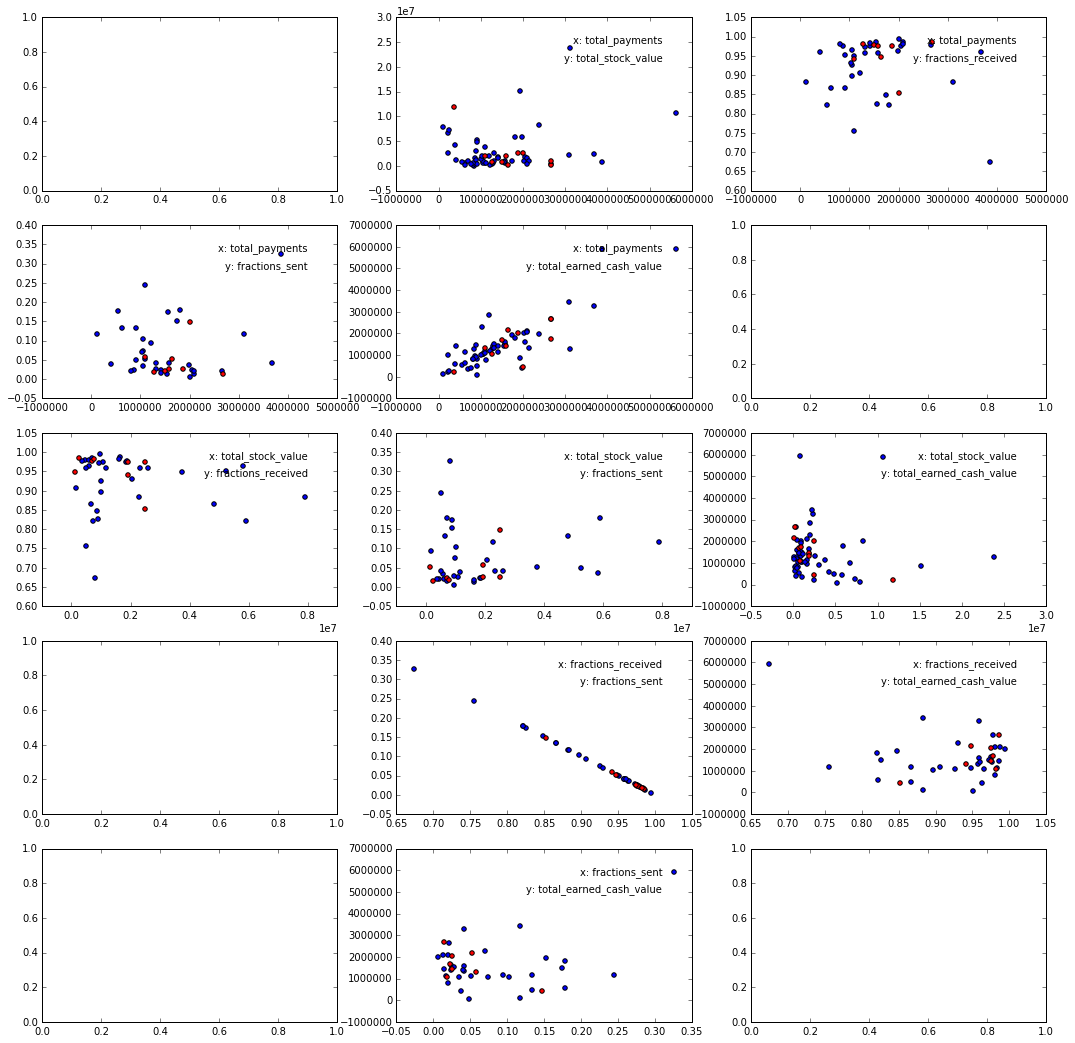

In [15]:
features_list = ["total_payments", "total_stock_value", "fractions_received", 
                 "fractions_sent", "total_earned_cash_value"]

cut = (data_df.bonus < data_df.bonus.quantile(0.9)) & \
    (data_df.salary < data_df.salary.quantile(0.9)) &\
    (data_df.from_this_person_to_poi < data_df.from_this_person_to_poi.quantile(0.9)) &\
    (data_df.long_term_incentive < data_df.long_term_incentive.quantile(0.9))
    
test_df = data_df[cut]

megaplot(test_df, features_list)

In [16]:
my_data = data_df[cut].fillna(0).to_dict(orient="index")

for key in my_data:
    the_name = my_data[key]["employee"]
    my_data[the_name] = my_data.pop(key)

### Extract features and labels from dataset for local testing
Rewriting this so that it works with my dataframe

In [33]:
features_list = ["poi", "total_payments", "total_stock_value", "fractions_received", 
                 "fractions_sent", "total_earned_cash_value", "other"]
data = featureFormat(my_data, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a Variety of Classifiers
Please name your classifier clf for easy export below.
Note that if you want to do PCA or other multi-stage operations,
you'll need to use Pipelines. For more info:
http://scikit-learn.org/stable/modules/pipeline.html

Let's start by finding some principal components amongst *all* features

In [34]:
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(n_components=5, whiten=False).fit(features)
features_pca = pca.transform(features)

In [35]:
features_pca.shape

(65, 5)

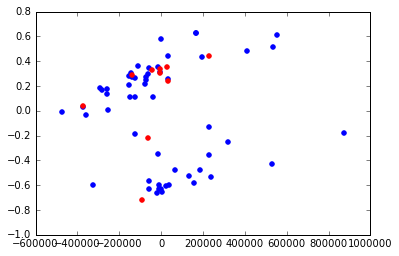

In [36]:
plt.scatter(features_pca[:,3][np.where(np.array(labels) == 0.0)], 
            features_pca[:,4][np.where(np.array(labels) == 0.0)],
           color="b")

plt.scatter(features_pca[:,3][np.where(np.array(labels) == 1.0)], 
            features_pca[:,4][np.where(np.array(labels) == 1.0)],
           color="r")
plt.show()

In [37]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split

In [38]:
def evaluate_classifiers(classifier_dict, features, labels):
    features_train, features_test, labels_train, labels_test = train_test_split(
        features, labels, test_size = 0.5, random_state = 42
    )
    
    for classifier in classifier_dict.keys():
        clf = classifier_dict[classifier]
        clf.fit(features_train, labels_train)
        pred = clf.predict(features_test)
        print "%s: \n\tAccuracy - %.6f \n\tPrecision - %.6f \n\tRecall - %.6f\n" % (classifier, 
                                                                                    accuracy_score(labels_test, pred), 
                                                                                    precision_score(labels_test, pred), 
                                                                                    recall_score(labels_test, pred))

In [39]:
classifiers = {"GaussianNB" : GaussianNB(), 
               "Decision Tree" : DecisionTreeClassifier(random_state=5),
              "KNearest" : KNeighborsClassifier(),
              "SVC" : SVC(C = 0.1)}
evaluate_classifiers(classifiers, features, labels)

KNearest: 
	Accuracy - 0.787879 
	Precision - 0.000000 
	Recall - 0.000000

GaussianNB: 
	Accuracy - 0.575758 
	Precision - 0.111111 
	Recall - 0.142857

SVC: 
	Accuracy - 0.787879 
	Precision - 0.000000 
	Recall - 0.000000

Decision Tree: 
	Accuracy - 0.757576 
	Precision - 0.333333 
	Recall - 0.142857

